# 实验三：参数估计 & 非参数估计
- 姓名: 王茂增
- 学号: 2113972
- 专业: 计算机科学与技术
- 代码: https://github.com/mzwangg/MachineLearning

## 实验要求
### 截止日期：11月3日
作业的提交格式参考之前的说明，提交到18329300691@163.com
### 基本要求
生成两个各包含 N=1000 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$, $p(w_2)=0.3$, $p(w_3)=0.1$


<img src="https://i.loli.net/2021/03/31/7WT8naYPQc9N56x.png" alt="image.png" style="zoom: 40%;" /> 
<img src="https://i.loli.net/2021/03/31/qsetFODzM7IhYaN.png" alt="image.png" style="zoom:40%;" />

在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。


### 中级要求
在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 高级要求
在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计
结果

## 导入需要的包

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

1. 为了实验的可复现性，设置随机数种子
1. 忽略警告信息，使其不显示在控制台上。
2. 设置Matplotlib的字体为宋体（SimHei），以显示中文字符。
3. 设置Matplotlib不显示负号为Unicode字符，以确保正确显示负号。

In [2]:
np.random.seed(1)# 为了实验的可复现性，设置随机数种子
warnings.filterwarnings("ignore") # 不显示warning
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 显示负号

## 基本要求

### 生成数据
1. 计算不同分布的个数，对于不能整除的部分，将比例作为概率，随机增加某个分布的个数
2. 通过np.random.multivariate_normal生成指定均值、方差、个数的数据，并在数据集最后增加一列标签，然后合并分布

In [3]:
def data_generate(N, mean, cov, p_w):
    # 计算不同分布的个数
    num = [int(N*p) for p in p_w]
    # 对于不能整除的部分，将比例作为概率，随机增加某个分布的个数
    for i in range(N - num[0] - num[1] - num[2]):
        r = np.random.rand()
        if r < p_w[0]:
            num[0] += 1
        elif r < p_w[0] + p_w[1]:
            num[1] += 1
        else:
            num[2] += 1
    
    # 生成分布
    X = []
    for i in range(len(num)):
        # 通过np.random.multivariate_normal生成指定均值、方差、个数的数据
        x, y = np.random.multivariate_normal(mean[i], cov, num[i]).T
        # 在数据集最后增加一列标签
        z = np.ones(num[i]) * i
        # 合并分布
        X.append(np.array([x, y, z]).T)
    
    return np.vstack(X)

1. 设置数量、均值、协方差先验概率
2. 生成数据集

In [4]:
# 参数设置
N = 1000  # 数据点数量
mean = [[1, 4], [4, 1], [8, 4]] # 均值列表
cov = 2 * np.eye(2)  # 协方差矩阵
p_w1 = [1/3, 1/3, 1/3] # X1先验概率
p_w2 = [0.6, 0.3, 0.1] # x2先验概率

# 数据生成
X1 = data_generate(N, mean, cov, p_w1)
X2 = data_generate(N, mean, cov, p_w2)

展示数据

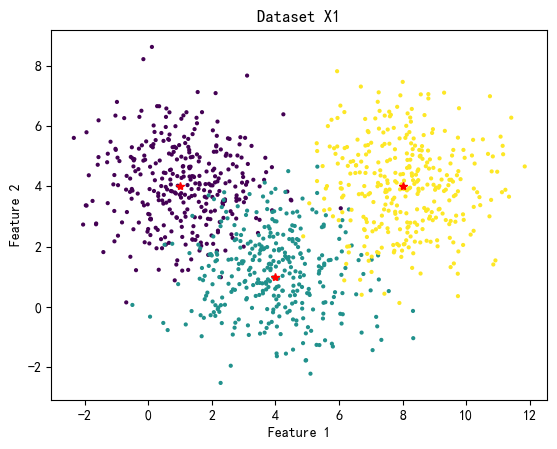

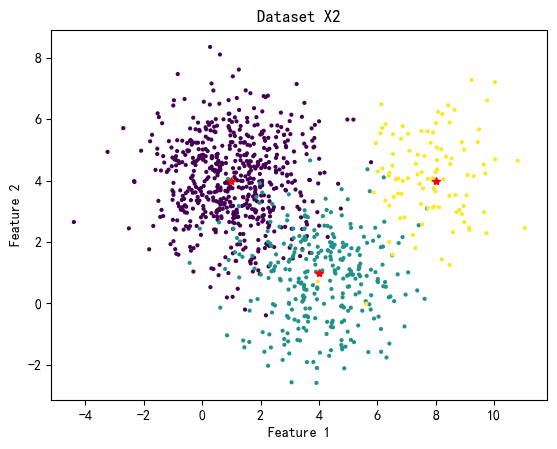

In [5]:
def show_data(X, name):
    # 根据最后一列的值确定颜色
    plt.scatter(X[:, 0], X[:, 1], s=4, c = X[:, 2])
    for i in range(X.shape[1]):
        plt.plot(mean[i][0], mean[i][1], 'r*')
    plt.title('Dataset ' + name)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

show_data(X1, 'X1')
show_data(X2, 'X2')

### 计算极大似然均值、协方差

均值的极大似然估计:
$$\hat{\boldsymbol{\mu}} = \frac{1}{N} \sum_{i=1}^{N} \boldsymbol{x}_i$$

协方差矩阵的极大似然估计:
$$\hat{\boldsymbol{\Sigma}} = \frac{1}{N} \sum_{i=1}^{N} (\boldsymbol{x}_i - \hat{\boldsymbol{\mu}})(\boldsymbol{x}_i - \hat{\boldsymbol{\mu}})^\top$$

而协方差的计算公式：
$$\text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})$$

所以均值的极大似然估计为**样本均值**，协方差的极大似然估计为**样本协方差**

通过上述方法计算每个数据集的极大似然均值和协方差

In [6]:
# 定义极大似然估计函数
def MLE(X):
    mean = np.mean(X, axis=0)
    cov = np.cov(X, rowvar=False)
    return mean, cov

# 定义函数来进行极大似然估计并输出结果
def estimate_and_print(X, name):
    num_classes = len(X) # 计算类别数目
    mu_list, cov_list = [], []

    for label in range(num_classes):
        mu, cov = MLE(X[label])
        mu_list.append(mu)
        cov_list.append(cov)

    mean = np.array(mu_list)
    cov = np.array(cov_list)
    print(f"{name}数据集mean参数估计为:\n", mean)
    print(f"{name}数据集cov参数估计为(按不同label):", cov)

    return mean, cov

# 为X1和X2分别进行极大似然估计并输出结果
X1_list = [X1[X1[:, 2] == i][:, 0:2] for i in range(3)]
X2_list = [X2[X2[:, 2] == i][:, 0:2] for i in range(3)]
mean1, cov1 = estimate_and_print(X1_list, "X1")
mean2, cov2 = estimate_and_print(X2_list, "X2")

X1数据集mean参数估计为:
 [[1.08426569 4.0662128 ]
 [3.94073522 1.13487193]
 [8.07058801 4.01514368]]
X1数据集cov参数估计为(按不同label): [[[ 1.85131191 -0.07869218]
  [-0.07869218  1.80781286]]

 [[ 2.11619684 -0.11828979]
  [-0.11828979  1.82016534]]

 [[ 1.90632771 -0.05751001]
  [-0.05751001  2.19722141]]]
X2数据集mean参数估计为:
 [[1.06418611 3.99754364]
 [4.00124783 0.88083976]
 [7.81744991 4.13155469]]
X2数据集cov参数估计为(按不同label): [[[ 1.98517144 -0.02506539]
  [-0.02506539  1.92563135]]

 [[ 2.22093541 -0.06983281]
  [-0.06983281  2.01962765]]

 [[ 1.54177503  0.22939688]
  [ 0.22939688  1.97371538]]]


### 分类实验

**二元正太分布概率密度函数**：
$$
f(\mathbf{x}; \mathbf{\mu}, \mathbf{\Sigma}) = \frac{1}{2\pi |\mathbf{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^\top \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu})\right)
$$

**似然率测试规则**：通过该分布以及数据集的极大似然均值和协方差，计算每个样本属于每个分布的概率，选择最大的一个。

**最大后验概率规则**：通过该分布以及数据集的极大似然均值和协方差，计算每个样本属于每个分布的概率，并**乘以先验概率**，选择最大的一个。

In [7]:
# 定义多元正态分布概率密度函数
def multi_normal(x, mean, cov):
    det_cov = np.linalg.det(cov.tolist()) # 计算方差矩阵的行列式
    inv_cov = np.linalg.inv(cov.tolist()) # 计算方差矩阵的逆
    constant = 1 / (2 * np.pi * np.sqrt(det_cov))
    exponent = -0.5 * np.dot(np.dot((x - mean).T,inv_cov), (x - mean))
    p = constant * np.exp(exponent)
    return p

# 似然率测试规则
def MLE_rule(x, mean, cov):
    likelihoods = [multi_normal(x, mean[i], cov[i]) for i in range(len(mean))]
    return np.argmax(likelihoods)

# 最大后验概率规则
def MAP_rule(x, mean, cov, p_w):
    posterior_probs = [p_w[i] * multi_normal(x, mean[i], cov[i]) for i in range(len(mean))]
    return np.argmax(posterior_probs)

调用似然率测试规则函数和最大后验概率规则函数，计算每个样本属于每个分布的概率，并输出结果。

In [8]:
# 应用似然率测试规则并计算分类错误率
X1_MLE_wrong_num = 0
X2_MLE_wrong_num = 0
# 进行分类
for i in range(N):
    predict = MLE_rule(X1[i, 0:2], mean1, cov1)
    if predict != X1[i, 2]:
        X1_MLE_wrong_num += 1
    predict = MLE_rule(X2[i, 0:2], mean2, cov2)
    if predict != X2[i, 2]:
        X2_MLE_wrong_num += 1
# 计算分类错误率
X1_MLE_wrong_rate = X1_MLE_wrong_num / N
X2_MLE_wrong_rate = X2_MLE_wrong_num / N

# 应用最大后验概率规则并计算分类错误率
X1_MAP_wrong_num = 0
X2_MAP_wrong_num = 0
# 进行分类
for i in range(N):
    predict = MAP_rule(X1[i, 0:2], mean1, cov1, p_w1)
    if predict != X1[i, 2]:
        X1_MAP_wrong_num += 1
    predict = MAP_rule(X2[i, 0:2], mean2, cov2, p_w2)
    if predict != X2[i, 2]:
        X2_MAP_wrong_num += 1
# 计算分类错误率
X1_MAP_wrong_rate = X1_MAP_wrong_num / N
X2_MAP_wrong_rate = X2_MAP_wrong_num / N

# 输出结果
print("似然率测试规则分类错误率 (X1):", X1_MLE_wrong_rate)
print("似然率测试规则分类错误率 (X2):", X2_MLE_wrong_rate)
print("最大后验概率规则分类错误率 (X1):", X1_MAP_wrong_rate)
print("最大后验概率规则分类错误率 (X2):", X2_MAP_wrong_rate)

似然率测试规则分类错误率 (X1): 0.066
似然率测试规则分类错误率 (X2): 0.085
最大后验概率规则分类错误率 (X1): 0.066
最大后验概率规则分类错误率 (X2): 0.07


**实验现象**：

- 在X1数据集中，使用最大似然以及最大后验概率得到的错误率均为0.066，表明两者在X1的分类性能相当。

- 在X2数据集中，使用最大似然函数的错误率为0.085，最大后验概率的错误率均为0.07，表明在数据集X2中，使用最大似然的性能更优。

**结果分析**：

- 在X1中错误率相同是一定的，因为使用两种方法计算的概率只是相差一个常数倍，概率最大的类别一定相同，错误率也就一定相同。

- 在X2中是由于X2中各分布的先验概率不同，如果使用最大似然，则相当于将三种分布的先验概率均看成1/3，而最大后验使用了正确的先验概率，计算的概率更加准确。

## 中级要求

**高斯核概率密度函数**:
$$\hat{f}(x) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{\sqrt{2\pi h^2}} \exp\left(-\frac{{\|x - x_i\|^2}}{2h^2}\right)$$

**似然率测试规则**：通过该分布以及数据集的极大似然均值和协方差，计算每个样本属于每个分布的概率，选择最大的一个。

**最大后验概率规则**：通过该分布以及数据集的极大似然均值和协方差，计算每个样本属于每个分布的概率，并**乘以先验概率**，选择最大的一个。

In [9]:
# 高斯核概率密度函数计算
def Gaussian_Kernel(x, X, h=2):
    # 计算概率p(x|w)
    p = (1 / (np.sqrt(2 * np.pi) * h)) * np.array([np.exp(-0.5 * np.dot(x - X[i], x - X[i]) / (h**2)) for i in range(len(X))]).mean()
    return p

# 高斯核函数+似然率测试规则
# 为了参数统一，加入p_w参数，但是并不使用
def Gaussian_MLE_rule(x, X, h, p_w):
    p = [Gaussian_Kernel(x, X[i], h) for i in range(len(X))]
    return np.argmax(p)

# 高斯核函数+最大后验概率测试规则
def Gaussian_MAP_rule(x, X, h, p_w):
    p = [p_w[i] * Gaussian_Kernel(x, X[i], h) for i in range(len(X))]
    return np.argmax(p)

使用留一法进行交叉验证，并返回错误率

In [10]:
def LOOCV(X, h_values, func, p_w):
    error_rates = []
    # 对不同的h值进行测试
    for h in h_values:
        error_count = 0
        for j in range(len(X)):
            for i in range(len(X[j])):
                X_local = []
                for k in range(3):
                    if k == j:
                        # 从原始数据集中提出本条数据
                        X_local.append(np.vstack((X[k][:i], X[k][i+1:])))
                    else:
                        X_local.append(X[k])
                # 进行分类
                predict = func(X[j][i], X_local, h, p_w)
                error_count += int(predict!=j)
        error_rates.append(error_count/N)
    return error_rates


对每个数据集和方法进行交叉验证

In [11]:
h_values = [0.1,0.5,1,1.5,2]

# X1数据集
MLE_X1_error_rate = LOOCV(X1_list, h_values, Gaussian_MLE_rule, p_w1)
MAP_X1_error_rate = LOOCV(X1_list, h_values, Gaussian_MAP_rule, p_w1)

# X2数据集
MLE_X2_error_rate = LOOCV(X2_list, h_values, Gaussian_MLE_rule, p_w2)
MAP_X2_error_rate = LOOCV(X2_list, h_values, Gaussian_MAP_rule, p_w2)

输出最佳h值和错误率列表并可视化

MLE_X1 best h:  1.5
MLE_X1_error_rate:  [0.092, 0.067, 0.067, 0.066, 0.066]
MAP_X1 best h:  1.5
MAP_X1_error_rate:  [0.092, 0.067, 0.067, 0.066, 0.066]
MLE_X2 best h:  2
MLE_X2_error_rate:  [0.107, 0.088, 0.084, 0.084, 0.082]
MAP_X2 best h:  1
MAP_X2_error_rate:  [0.102, 0.071, 0.068, 0.075, 0.095]


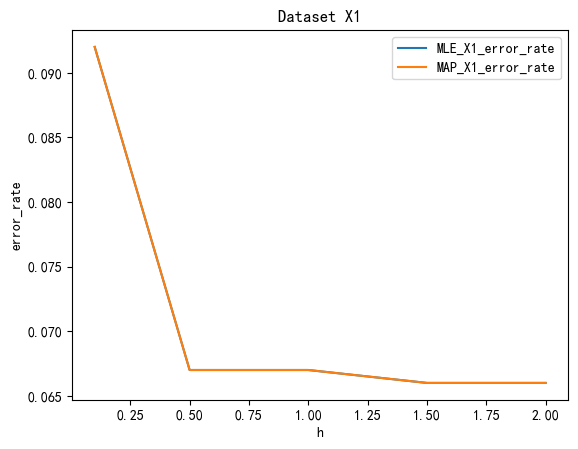

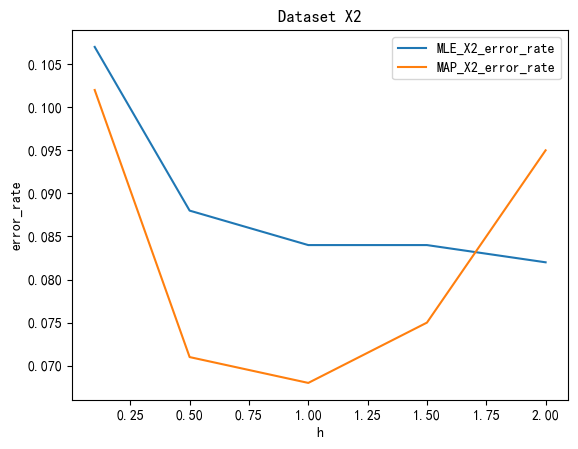

In [15]:
# 输出最佳h值和错误率列表
print("MLE_X1 best h: ", h_values[np.argmin(MLE_X1_error_rate)])
print("MLE_X1_error_rate: ", MLE_X1_error_rate)
print("MAP_X1 best h: ", h_values[np.argmin(MAP_X1_error_rate)])
print("MAP_X1_error_rate: ", MAP_X1_error_rate)
print("MLE_X2 best h: ", h_values[np.argmin(MLE_X2_error_rate)])
print("MLE_X2_error_rate: ", MLE_X2_error_rate)
print("MAP_X2 best h: ", h_values[np.argmin(MAP_X2_error_rate)])
print("MAP_X2_error_rate: ", MAP_X2_error_rate)


# 进行可视化
plt.plot(h_values, MLE_X1_error_rate, label = "MLE_X1_error_rate")
plt.plot(h_values, MAP_X1_error_rate, label = "MAP_X1_error_rate")
plt.title("Dataset X1")
plt.xlabel('h')
plt.ylabel('error_rate')
plt.legend()
plt.show()

plt.plot(h_values, MLE_X2_error_rate, label = "MLE_X2_error_rate")
plt.plot(h_values, MAP_X2_error_rate, label = "MAP_X2_error_rate")
plt.title("Dataset X2")
plt.xlabel('h')
plt.ylabel('error_rate')
plt.legend()
plt.show()

**X1数据集**：

1. 两种方法在不同h时的错误率均相同，这是显然的，因为两者得出的概率只相差常数倍，相对大小关系不变，得出的最大概率的类别也就不变。

2. 观察错误率随h变化的图像，首先急剧下降，最后基本不变。这是由于当h较小时，可能受到随机因素的干扰；当h大到一定程度后，由于难以分类数据一般位于多种分布的交界处，由于不同分布的先验概率相同，扩大了h也会同等比例增加各个分布的数量，使得错误率并没有减小。

**X2数据集**：

1. 首先可以观察到最大后验概率得到的最低错误率要优于最大似然，这是由于最大后验概率使用了准确的先验概率，而最大似然将每种分布的先验概率视为一致。

2. 最大似然随着h的变大错误率不断变低，这是由于X2数据集各个分布的先验概率不一致，对于在多个分布之间的难分类数据会由于h的增大更加倾向于先验概率更高的类别，使得错误率逐渐降低。

3. 最大后验概率的错误率随着h的变大先变小再变大，这是由于在一定范围内，越大的h能降低偶然的发生，降低错误率；而当h更大之后，在多个分布之间的难分类数据会由于h的增大更加倾向于先验概率更高的类别，而最大后验本身已经有了正确的先验概率，再向先验概率更高的分类靠拢反而会导致先验概率错误，从而提高错误率。

## 高级要求

**k最近邻概率密度函数**：
$$ P _ { n } ( x ) = \frac { k _ { n } / n } { V _ { n } }  $$

通过留一法的交叉验证找到最优k值。

In [17]:
# k最近邻概率密度函数
def knn_density_estimation(x, X, k):
    distances = np.linalg.norm(X[:, :2] - x, axis=1)
    nearest_indices = np.argsort(distances)[:k]
    nearest_X = X[nearest_indices]
    S = np.pi * (distances[nearest_indices[k-1]]**2)
    p = [sum(nearest_X[:,2]==i)/N/S for i in range(3)]
    return np.argmax(p)

# 交叉验证
def LOOCV_knn(X, k_values, func):
    error_rates = []
    # 对不同的k值进行测试
    for k in k_values:
        error_count = 0
        for i in range(len(X)):
            # 剔除当前数据
            X_local = np.vstack((X[:i], X[i+1:]))
            # 进行预测
            predict = func(X[i, :2], X_local, k)
            error_count += int(predict!=X[i, 2])
        error_rates.append(error_count/N)
    return error_rates

# 进行交叉验证
k_values = [1, 3, 5, 7, 9, 11 ,13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]
knn_X1_error_rate = LOOCV_knn(X1, k_values, knn_density_estimation)
knn_X2_error_rate = LOOCV_knn(X2, k_values, knn_density_estimation)

输出最优k值和错误率列表，并进行可视化

X1 best k:  35
knn_X1_error_rate:  [0.102, 0.08, 0.078, 0.075, 0.073, 0.072, 0.073, 0.069, 0.069, 0.069, 0.072, 0.069, 0.07, 0.069, 0.068, 0.07, 0.068, 0.066, 0.068, 0.069]
X2 best k:  27
knn_X2_error_rate:  [0.11, 0.092, 0.091, 0.081, 0.084, 0.075, 0.073, 0.072, 0.075, 0.073, 0.073, 0.071, 0.068, 0.065, 0.068, 0.07, 0.067, 0.066, 0.067, 0.067]


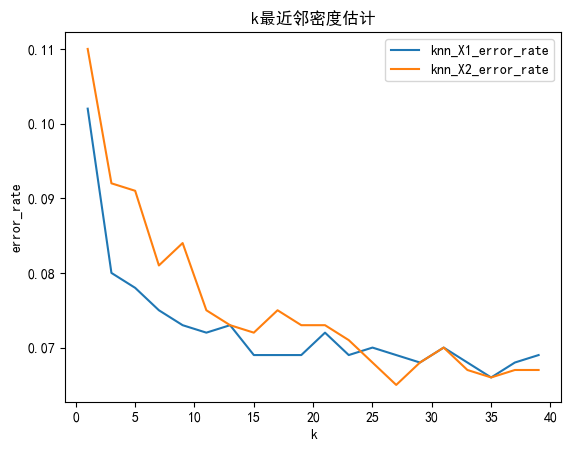

In [18]:
# 输出最优k值和错误率列表
print("X1 best k: ", k_values[np.argmin(knn_X1_error_rate)])
print("knn_X1_error_rate: ", knn_X1_error_rate)
print("X2 best k: ", k_values[np.argmin(knn_X2_error_rate)])
print("knn_X2_error_rate: ", knn_X2_error_rate)

# 进行可视化
plt.plot(k_values, knn_X1_error_rate, label = "knn_X1_error_rate")
plt.plot(k_values, knn_X2_error_rate, label = "knn_X2_error_rate")
plt.title("k最近邻密度估计")
plt.xlabel('k')
plt.ylabel('error_rate')
plt.legend()
plt.show()

由结果可知，X1数据集的最优k值为35, X2数据集的最优k值为27。并且随着k的增加，错误率逐渐降低，但是降低的幅度逐渐放缓。

这是由于当k较小时，可能受到随机因素的干扰；当k大到一定程度后，由于难以分类数据一般位于多种分布的交界处，由于不同分布的先验概率相同，扩大了h也会同等比例增加各个分布的数量，使得错误率并没有减小。